In [1]:
import json 


def read_json(path):
    with open(path) as f1:
        data = [json.loads(x) for x in f1]
    return data


path = "/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/bart-large_spider_past_none_db_val_all_0.0001_5000_test_eval_unconstrained-beam_bs_5/model_outputs.20230208T031316.jsonl" 

data = read_json(path)








# Factors making examples easy and hard
Which factors make an example easy or hard? We will look at 3 factors:
- length (numer of tokens)
- number of sentences 
- percentage of value op values that are present in the source 

## Length

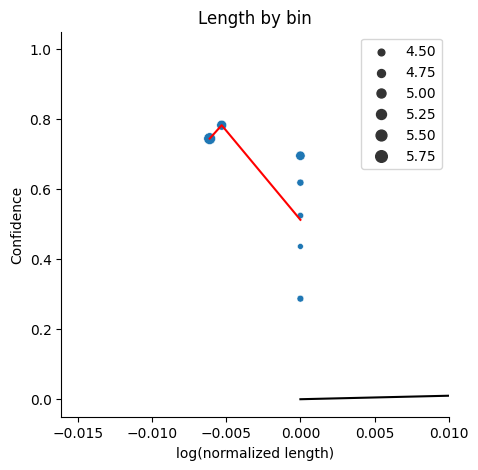

In [5]:
import re
import numpy as np 
# get input length
from matplotlib import pyplot as plt 

from calibration_metric import ECEMetric
from calibration_metric.vis.calibration_plot import plot_df

def get_lengths_and_confidences(data):
    lens = []
    confs = []
    for example in data:
        utt = re.split(" , ", example['test_datum_natural'])[-1]
        input_str = utt.strip()
        input_str = re.split("\s+", input_str) 
        lens.append(len(input_str)) 
        token_probs = np.exp(example['token_logprobs'][0])
        min_conf = np.min(token_probs) 
        # min_conf = np.min(example['top_logits'], axis=-1)
        confs.append(min_conf)
    lens = np.array(lens)
    # normalize lengths
    max_len = np.max(lens)
    min_len = np.min(lens)
    len_range = max_len - min_len
    lens = (lens - min_len) / len_range

    confs = np.array(confs)
    metric = ECEMetric(binning_strategy='adaptive', return_df=True)
    values, bin_edges, bin_number = metric.bin_preds(confs, lens)
    df = metric.bins_to_df(values, bin_edges, bin_number)

    return df 


len_df = get_lengths_and_confidences(data)
fig, ax = plt.subplots(1,1, figsize=(5, 5))
# take log of normalized length
len_df['prob_correct'] = np.log(len_df['prob_correct'])

plot_df(df = len_df,
        use_log_count=True,
        ax=ax,
        title="Length by bin",
        xlabel="log(normalized length)",
        ylabel="Confidence")

ax.set_xlim(len_df['prob_correct'].min()-0.01, len_df['prob_correct'].max()+0.01)
# sort by length
len_df = len_df.sort_values(by='prob_correct')
# fit 2nd order polynomial
fit = np.polyfit(len_df['prob_correct'], len_df['prob_model'], 2)
ax.plot(len_df['prob_correct'], np.polyval(fit, len_df['prob_correct']), color='red')

Clear negative correlation between log normalized length and confidence; Longer programs are lower confidence

TODO: Fit a line

## Percentage of examples with multiple sentences
For each dataset, what percentage of examples have more than one sentence (as measured by the presence of a period)

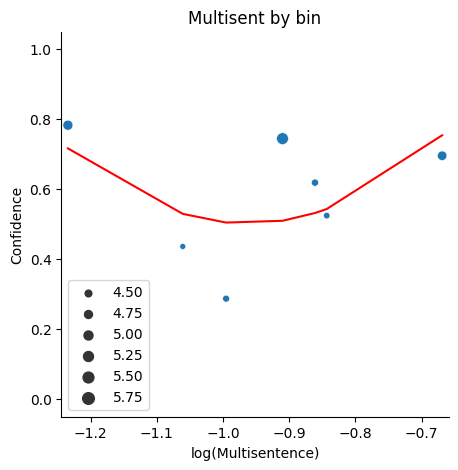

In [7]:
def get_multisent_and_confidences(data):
    multis = []
    confs = []
    for example in data:
        utt = re.split(" , ", example['test_datum_natural'])[-1]
        input_str = utt.strip()
        input_str = re.sub("\.", " . ", input_str)
        split_input = re.split("\s+", input_str) 
        if split_input[-1] == ".":
            split_input = split_input[0:-1]
        if "." in split_input: 
            period_index = split_input.index(".")
            try:
                before, after = split_input[period_index-1], split_input[period_index+1]
                # check if they're numbers 
                if before.isdigit() and after.isdigit():
                    continue
            except IndexError:
                pass
            multi_sent = 1 
        else:
            multi_sent = 0
        multis.append(multi_sent)
        token_probs = np.exp(example['token_logprobs'][0])
        min_conf = np.min(token_probs) 
        confs.append(min_conf)

    multis = np.array(multis)
    confs = np.array(confs)

    metric = ECEMetric(binning_strategy='adaptive', return_df=True)
    values, bin_edges, bin_number = metric.bin_preds(confs, multis)
    df = metric.bins_to_df(values, bin_edges, bin_number)

    return df 


multi_df = get_multisent_and_confidences(data)
multi_df['prob_correct'] = np.log(multi_df['prob_correct'])

fig, ax = plt.subplots(1,1, figsize=(5, 5))
plot_df(df = multi_df,
        use_log_count=True,
        ax=ax,
        title="Multisent by bin",
        xlabel="log(Multisentence)",
        ylabel="Confidence")


ax.set_xlim(multi_df['prob_correct'].min()-0.01, multi_df['prob_correct'].max()+0.01)
# sort by length
multi_df = multi_df.sort_values(by='prob_correct')
# fit 2nd order polynomial
fit = np.polyfit(multi_df['prob_correct'], multi_df['prob_model'], 2)
ax.plot(multi_df['prob_correct'], np.polyval(fit, multi_df['prob_correct']), color='red')


## Copying
For TreeDST, it seems like a lot of hard examples are based on not having access to enough context.
We will see what percentage of values_op values we can copy from the input 

/brtx/601-nvme1/estengel/miniconda3/envs/bclamp2/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


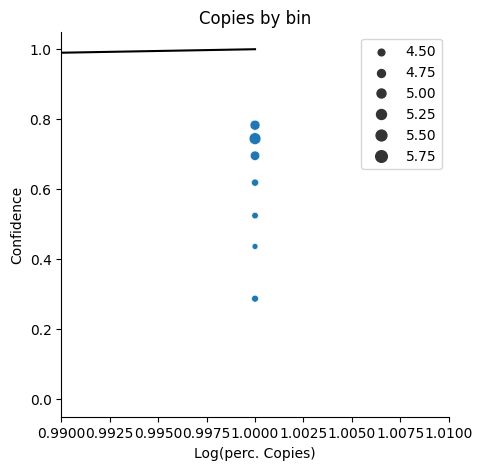

In [20]:
## get set of value ops 
from dataflow.core.lispress import parse_lispress, lispress_to_program
from dataflow.core.program import ValueOp

def get_values(sql):
    sql = re.split("\s+", sql)
    all_values = []
    # values are all lowercase tokens
    for token in sql:
        if token.islower():
            all_values.append(token)
    return all_values 

def get_copies_and_confidences(data):
    copies = []
    confs = []
    for example in data:
        # use full context 
        input_str = example['test_datum_natural'].strip()
        input_str = re.sub("\.", " . ", input_str)
        split_input = re.split("[\s+\|]", input_str) 
        split_input = [x for x in split_input if x not in ['', ',', ':']]
        split_input = [x.lower().strip() for x in split_input]
        value_ops = get_values(example['test_datum_canonical'])
        # get percentage of value ops in input 
        in_input, total = 0, 0
        for v in value_ops:
            if v in split_input:
                in_input += 1
            total += 1
        if total > 0:
            c = in_input/total
        else:
            c = 0
        copies.append(c)
        token_probs = np.exp(example['token_logprobs'][0])
        min_conf = np.min(token_probs) 
        confs.append(min_conf)

    confs = np.array(confs)
    copies = np.array(copies)

    # check for nans
    assert np.sum(np.isnan(copies)) == 0
    assert np.sum(np.isnan(confs)) == 0
    # check for infs
    assert np.sum(np.isinf(copies)) == 0
    assert np.sum(np.isinf(confs)) == 0

    metric = ECEMetric(binning_strategy='adaptive', return_df=True)
    values, bin_edges, bin_number = metric.bin_preds(confs, copies)
    df = metric.bins_to_df(values, bin_edges, bin_number)

    return df 

copies_df = get_copies_and_confidences(data)
# copies_df['prob_correct'] = np.log(copies_df['prob_correct'])
assert np.sum(np.isnan(copies_df['prob_correct'])) == 0
assert np.sum(np.isinf(copies_df['prob_correct'])) == 0

fig, ax = plt.subplots(1,1, figsize=(5, 5))
plot_df(df = copies_df,
        use_log_count=True,
        ax=ax,
        title="Copies by bin",
        xlabel="Perc. Copies",
        ylabel="Confidence")

ax.set_xlim(copies_df['prob_correct'].min()-0.01, copies_df['prob_correct'].max()+0.01)
# sort by length
copies_df = copies_df.sort_values(by='prob_correct')
# fit 2nd order polynomial
fit = np.polyfit(copies_df['prob_correct'], copies_df['prob_model'], 2)

ax.plot(copies_df['prob_correct'], np.polyval(fit, copies_df['prob_correct']), color='red')

